<a href="https://colab.research.google.com/github/sophiascarano/hybrid_quantum_classical_KiUNet/blob/main/messy_drafts/torch_u.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# yet another test

In [ ]:
import torch

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name Tesla P100-PCIE-16GB


In [ ]:
import torch.nn as nn
import torchvision.models


def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = torchvision.models.resnet18(pretrained=True)
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

In [ ]:
import torch
import torch.nn as nn
#import pytorch_unet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)

model = ResNetUNet(6)
model = model.to(device)

device cuda


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
model

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
from torchsummary import summary
#summary(model, input_size=(3, 224, 224))
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5         [-1, 64, 128, 128]           9,408
            Conv2d-6         [-1, 64, 128, 128]           9,408
       BatchNorm2d-7         [-1, 64, 128, 128]             128
       BatchNorm2d-8         [-1, 64, 128, 128]             128
              ReLU-9         [-1, 64, 128, 128]               0
             ReLU-10         [-1, 64, 128, 128]               0
        MaxPool2d-11           [-1, 64, 64, 64]               0
        MaxPool2d-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]          36,864
           Conv2d-14           [-1, 64,

In [ ]:
from collections import defaultdict
import torch.nn.functional as F
# from loss import dice_loss

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final

checkpoint_path = "checkpoint.pth"

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = DiceBCELoss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            if phase == 'train':
              scheduler.step()
              for param_group in optimizer.param_groups:
                  print("LR", param_group['lr'])

            # save the model weights
            if phase == 'val' and epoch_loss < best_loss:
                print(f"saving best model to {checkpoint_path}")
                best_loss = epoch_loss
                torch.save(model.state_dict(), checkpoint_path)

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(torch.load(checkpoint_path))
    return model

In [ ]:
dataloaders = {
  train_loader,
  test_loader
}

In [ ]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time

num_class = 6
model = ResNetUNet(num_class).to(device)

# freeze backbone layers
for l in model.base_layers:
  for param in l.parameters():
    param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


TypeError: ignored

# imports

In [ ]:
# Loading libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from statistics import mean
from torch.autograd import Variable
import time
from PIL import Image
import random
from skimage import io, transform
from collections import OrderedDict
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from matplotlib import pyplot as plt
from skimage import io, transform
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# data loading

In [ ]:
csv_path =  '/content/drive/My Drive/Colab_Notebooks/brain_tumor/data/lgg-mri-segmentation/kaggle_3m/data.csv'
data_folder = '/content/drive/My Drive/Colab_Notebooks/brain_tumor/data/lgg-mri-segmentation/kaggle_3m/'
eg_path = '/content/drive/My Drive/Colab_Notebooks/brain_tumor/data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809'
eg_img = '/content/drive/My Drive/Colab_Notebooks/brain_tumor/data/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_10.tif'
eg_mask = '/content/drive/My Drive/Colab_Notebooks/brain_tumor/data/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_10_mask.tif'

In [ ]:
class Brain_data(Dataset):
    def __init__(self,path):
        self.path = path
        self.patients = [file for file in os.listdir(path) if file not in ['data.csv','README.md']]
        self.masks,self.images = [],[]

        for patient in self.patients:
            for file in os.listdir(os.path.join(self.path,patient)):
                if 'mask' in file.split('.')[0].split('_'):
                    self.masks.append(os.path.join(self.path,patient,file))
                else: 
                    self.images.append(os.path.join(self.path,patient,file)) 
          
        self.images = sorted(self.images)
        self.masks = sorted(self.masks)
        
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image = self.images[idx]
        mask = self.masks[idx]
        image = io.imread(image)
        image = transform.resize(image,(256,256))
        image = image / 255
        image = image.transpose((2, 0, 1))
        
        
        mask = io.imread(mask)
        mask = transform.resize(mask,(256,256))
        mask = mask / 255
        mask = np.expand_dims(mask,axis=-1).transpose((2, 0, 1))

        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)
        
        return (image,mask)

In [ ]:
type(data_folder)

str

In [ ]:
data = Brain_data(data_folder)
print('Length of dataset is {}'. format(data.__len__()))
print('sample data: ')
data.__getitem__(1)

Length of dataset is 3929
sample data: 


(tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],
 
         [[3.0757e-05, 4.6136e-05, 4.6136e-05,  ..., 3.0757e-05,
           3.0757e-05, 3.0757e-05],
          [9.2272e-05, 3.0757e-05, 1.3266e-18,  ..., 1.5379e-05,
           1.5379e-05, 3.0757e-05],
          [4.6136e-05, 4.6136e-05, 4.6136e-05,  ..., 3.0757e-05,
           3.0757e-05, 3.0757e-05],
          ...,
          [4.6136e-05, 6.1515e-05, 4.6136e-05,  ..., 9.227

In [ ]:
# checking shape of data
for img,msk in data:
      print(img.shape)
      print(msk.shape)
      break

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


In [ ]:
len(data)

3929

In [ ]:
from sklearn.model_selection import train_test_split
# Split the indices in a stratified way
# indices = np.arange(len(data))
indices = np.arange(400)
train_indices, test_indices = train_test_split(indices, train_size=40)

# Warp into Subsets and DataLoaders
train_dataset = torch.utils.data.Subset(data, train_indices)
test_dataset = torch.utils.data.Subset(data, test_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=10)
val_loader = torch.utils.data.DataLoader(train_dataset, shuffle=False, batch_size=10)


In [ ]:
# splitting to trainset and validation set

#trainset, valset = random_split(data, [3600, 329],)

# trainset, valset = random_split(data, range(400), [360, 40])

# train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=10,shuffle=True)

# val_loader = torch.utils.data.DataLoader(dataset=valset, batch_size=10)

In [ ]:
# converting tensor to image
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255)
    return image

def mask_convert(mask):
    mask = mask.clone().cpu().detach().numpy()
    return np.squeeze(mask)

def plot_img(no_):
    iter_ = iter(train_loader)
    images,masks = next(iter_)
    # images = images.to(device)
    # masks = masks.to(device)
    plt.figure(figsize=(20,10))
    for idx in range(0,no_):
         image = image_convert(images[idx])
         plt.subplot(2,no_,idx+1)
         plt.imshow(image)
    for idx in range(0,no_):
         mask = mask_convert(masks[idx])
         plt.subplot(2,no_,idx+no_+1)
         plt.imshow(mask,cmap='gray')
    plt.show()

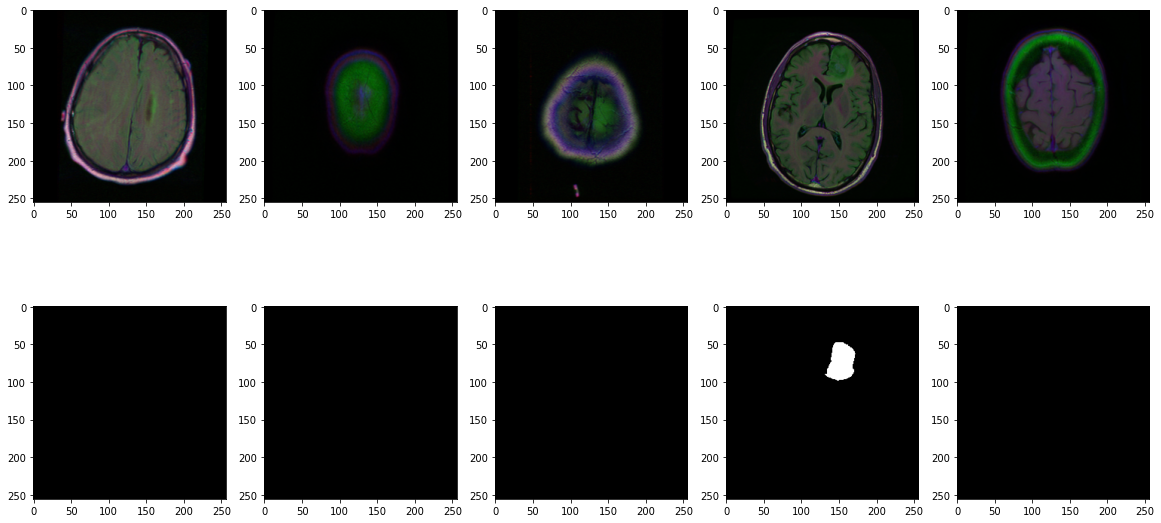

In [ ]:
plot_img(5)

#u net 256

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=(3,3),padding=1):
        super(ConvBlock,self).__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,kernel_size,padding=padding,bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels,eps=1e-4)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x
        
        
class StackEncoder(nn.Module):
    def __init__(self,channel1,channel2,kernel_size=(3,3),padding=1):
        super(StackEncoder,self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.block = nn.Sequential(
            ConvBlock(channel1,channel2,kernel_size,padding),
            #ConvBlock(channel2,channel2,kernel_size,padding),     
        )
        
    def forward(self,x):
        big_out = self.block(x)
        poolout = self.maxpool(big_out)
        return big_out,poolout
     
        
class StackDecoder(nn.Module):
    def __init__(self,big_channel,channel1,channel2,kernel_size=(3,3),padding=1):
        super(StackDecoder,self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channel1+big_channel,channel2,kernel_size,padding),
            #ConvBlock(channel2,channel2,kernel_size,padding),
            #ConvBlock(channel2,channel2,kernel_size,padding),
        )
        
    def forward(self,x,down_tensor):
            _, channels, height, width = down_tensor.size()  
            #x = F.upsample(x, size=(height, width), mode='bilinear')
            x = F.interpolate(x, size=(height, width), mode='bilinear', align_corners=True)
            x = torch.cat([x, down_tensor], 1)  #combining channels of  input from encoder and upsampling input
            x = self.block(x)
            return x

In [ ]:
class Unet256(nn.Module):
    def __init__(self,input_shape):
        super(Unet256,self).__init__()
        
        channel,height,width = input_shape
        
        self.down1 = StackEncoder(channel,12,kernel_size=(3,3))  #256
        self.down2 = StackEncoder(12,24,kernel_size=(3,3))  # 128
        #self.down3 = StackEncoder(24,46,kernel_size=(3,3))  # 64
        #self.down4 = StackEncoder(46,64,kernel_size=(3,3))  # 32
        #self.down5 = StackEncoder(64,128,kernel_size=(3,3))  #16
        
        #self.center = ConvBlock(128,128,kernel_size=(3,3),padding=1) #16
        
        #self.up5 = StackDecoder(128,128,64,kernel_size=(3,3))  #32
        #self.up4 = StackDecoder(64,64,46,kernel_size=(3,3)) #64
        #self.up3 = StackDecoder(46,46,24,kernel_size=(3,3))
        self.up2 = StackDecoder(24,24,12,kernel_size=(3,3))
        self.up1 = StackDecoder(12,12,12,kernel_size=(3,3))
        self.conv = Conv2d(12,1,kernel_size=(1,1),bias=True)
        
    def forward(self,x):
        down1,out = self.down1(x)  
        down2,out = self.down2(out)  
        #down3,out = self.down3(out)
        #down4,out = self.down4(out)
        #down5,out = self.down5(out)
        
        
        #out = self.center(out)
        
        #up5 = self.up5(out,down5)
        #up4 = self.up4(up5,down4)
        #up3 = self.up3(up4,down3)
        up2 = self.up2(out,down2)
        up1 = self.up1(up2,down1)
        
        out = self.conv(up1)


        return out

In [ ]:
# from torchsummary import summary
model = Unet256((3,256,256))#.to(device)
model

Unet256(
  (down1): StackEncoder(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (block): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batchnorm): BatchNorm2d(12, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
    )
  )
  (down2): StackEncoder(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (block): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batchnorm): BatchNorm2d(24, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
    )
  )
  (up2): StackDecoder(
    (block): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

# loss funcs

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final
    
    

class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU * 100

    
    
class DiceScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceScore, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_score = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth) 
        return dice_score

In [ ]:
criterion = DiceBCELoss()


learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
epochs = 10


train_loss = []
val_loss = []

for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    start_time = time.time()
     

    
    running_train_loss = []
    
    for image,mask in train_loader: 
            image = image.to(device,dtype=torch.float)
            mask = mask.to(device,dtype=torch.float)
            # image = image.to(dtype=torch.float)
            # mask = mask.to(dtype=torch.float)
            
            pred_mask = model.forward(image) # forward propogation
            loss = criterion(pred_mask,mask)
            optimizer.zero_grad() # setting gradient to zero
            loss.backward()
            optimizer.step()
            running_train_loss.append(loss.item())
                              

    else:           
        running_val_loss = []
        
        with torch.no_grad():
            for image,mask in val_loader:
                    image = image.to(device,dtype=torch.float)
                    mask = mask.to(device,dtype=torch.float)                            
                    pred_mask = model.forward(image)
                    loss = criterion(pred_mask,mask)
                    running_val_loss.append(loss.item())
                    

                                    
    
    epoch_train_loss = np.mean(running_train_loss) 
    print('Train loss: {}'.format(epoch_train_loss))                       
    train_loss.append(epoch_train_loss)
    
    epoch_val_loss = np.mean(running_val_loss)
    print('Validation loss: {}'.format(epoch_val_loss))                                
    val_loss.append(epoch_val_loss)
                      
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch 1/10


RuntimeError: ignored

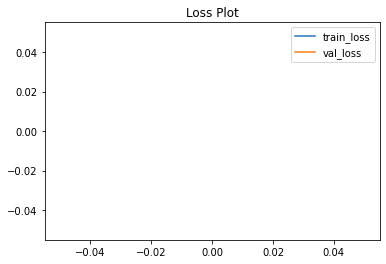

In [ ]:
plt.plot(train_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend()
plt.title('Loss Plot')
plt.show()